In [1]:
%matplotlib inline
import numpy as np
from numpy import exp, pi
from scipy.integrate import quad
from scipy.linalg import expm

# Our Strategy
We are faced with the serious problem that Rigatoni's drivetrain is inheretly non-linear: we must switch from using the motor to accelerate the car to using the brakes to decelerate the car.

We will address this by creating two cascaded controllers.
 * The first controller will take in the desired speed and determine the force the drivetrain (motor and brake) should develop. This is a fully linear system. We will write this as a continuous-time state-space PI controller with feed-forward.
 * The second controller will take in the desired force from the first controller and determine the necessary braking force or motor voltage.
   * If the force is > 0, it will apply discrete-time state-space PI control on the motor current
   * If the force is < 0, it will send the desired force to the brakes (open-loop control).

# Modeling the car physics

## Definitions

### Electrical
#### Variables
* $\tau$: motor torque, Nm
* $\omega$: motor rotational speed, rad/s
* $V$: voltage across the motor terminals (output of the motor driver)
* $V_{EMF}$: Motor's back-EMF voltage
* $u_D$: voltage command from our controller to the motor driver
* $I$: motor current

#### Constants
* $R$: Resistance of the motor windings
* $K_t$: Motor torque constant in $\frac{N m}{A}$
* $K_v$: Motor velocity constant in $\frac {V s}{radians}$
* $\lambda_c$: the location of the motor controller's pole

### Mechanical
#### Variables
* $v$: velocity of the car in m/s
* $a$: acceleration of the car in $\frac{m}{s^2}$
* $F_{net}$: Net force on the car in N
* $F_m$: The force the motor applies to the car through the wheels in N. Proportional to motor torque.
* $F_b$: The force the brake applies to the car through the wheels in N.
* $F_d = F_m - F_b$ is the net force the drivetrain (motor + brakes) develops in N.
* $\omega_{axle}$: rotational speed of the rear drive axle in rad/s
* $\tau_{axle}$: torque applied by motor/chain to the rear drive axle in Nm

#### Constants
* $m$: mass of the car in kg
* $d$: drag coefficient of the car in $\frac{Ns}{m}$
* $r_w$: car wheel radius in m
* $G_r$: gear ratio, expressed as shaft gear/motor gear. Larger than 1.

## Modeling the car's response to the drivetrain
![Car model](car_sum_forces.png)

Using Newton's Law, and lumping $F_d = F_m - F_b$:
$$ma = F_{net} = F_d - dv$$

Placing in canonical form
$$\dot{v} = a = -\frac{d}{m} v + \frac{1}{m} F_d$$

Lumping everything into constants:
$$ \dot{v} = -\gamma_{1F} v + \gamma_{2F} F_d $$

where
$$\gamma_{1F} = \frac{d}{m}$$
$$\gamma_{2F} = \frac{1}{m}$$

In [2]:
#Define mechanical constants
m = 150   #150 Check this
d = 10  #Calculated with 10   #TODO: find what the real drag constant is

gamma_1F = d/m
gamma_2F = 1/m

print(gamma_1F)
print(gamma_2F)

0.06666666666666667
0.006666666666666667


## Modeling the drivetrain
### Modeling the brakes
We have no feedback telling us the amount of force the brakes are developing. Therefore we cannot construct a controller for them. In this analysis, we assume that the brakes develop the commanded amount of force.

### Modeling the motor
[DC motor modeling](https://pages.mtu.edu/~wjendres/ProductRealization1Course/DC_Fotor_Calculations.pdf)

We will use the following equivalent circuit model for the brushed DC motor:

![motor model](dc-motor-equivalent-circuit.png "https://www.precisionmicrodrives.com/content/dc-motor-speed-voltage-and-torque-relationships/")

Ignoring the effects of the inductance, the fundamental equations are:
$$\tau = K_tI$$
$$V = V_{EMF} + IR$$
$$V_{EMF} = K_v \omega$$

Rearranging, we have:
$$V = K_v \omega + IR$$

or
$$I = \frac{V - K_v \omega}{R}$$

Plugging this back in, we arrive at the final equation for torque in terms of voltage and rotational speed:
$$\tau = \frac{K_t}{R} (V - K_v \omega)$$

### Converting motor torque and angular velocity to linear force and velocity
At the rear drive shaft we have
$$\omega_{axle} = \frac{\omega}{G_r}$$
$$\tau_{axle} = G_r \tau$$

Then
$$\omega = G_r \omega_{axle} = \frac{G_r v}{r_w}$$
$$F_m = \frac{\tau_{axle}}{r_w} = \frac{G_r}{r_w} \tau $$

Combining with the torque equation from above:
$$F_m = \frac{G_r K_t}{r_w R}(V - \frac{K_v G_r v}{r_w})$$

Solving that equation for V:
$$V = \frac{r_w R}{G_r K_t} F_m + \frac{K_v G_r v}{r_w}$$

### Modeling the effect of the motor driver
We do not control $V$ directly. Rather, we control $u_D$, the input to the motor driver, which then generates $V$. In an ideal world, $V = u_D$. However, the motor controller circuitry has some small response time which we will model as a first-order delay:
$$\frac{1}{\lambda_c} \dot{V} = -V + u_D$$

Rewriting:
$$ \dot{V} = -\lambda_c V + \lambda_c u_D = \lambda_c (u_D - V) $$

However, our controller wants a relation between $F_m$ and $u_D$, not $V$ and $u_D$. We already know $V$ in terms of $F_m$, however, we need to find $\dot{V}$:
$$ \dot{V} = \frac{r_w R}{G_r K_t} \dot{F_m} + \frac{K_v G_r}{r_w} \dot{v} $$

Since $v$ changes so slowly compared to $V$ for $F_m$, we can approximate $\dot{v} \approx 0$:
$$ \dot{V} = \frac{r_w R}{G_r K_t} \dot{F_m} $$

#### The final motor driver equation
Putting everything together:
$$ \frac{r_w R}{G_r K_t} \dot{F_m} = \lambda_c (u_D - \frac{K_v G_r v}{r_w} - \frac{r_w R}{G_r K_t} F_m) $$

In standard first-order form:
$$ \dot{F_m} = -\lambda_c F_m + \lambda_c \frac{G_r K_t}{r_w R} (u_D - \frac{K_v G_r v}{r_w}) $$

Packing everything into constants:
$$ \dot{F_m} = -\gamma_{1M} F_m + \gamma_{2M} (u_D - \gamma_{MV} v) $$

where
$$ \gamma_{1M} = \lambda_c $$
$$ \gamma_{2M} = \lambda_c \frac{G_r K_t}{r_w R} $$
$$ \gamma_{MV} = \frac{K_v G_r}{r_w} $$

In [3]:
#Mechanical constants
Gr = 64/22 #Gear ratio
rw = 0.27/2 #Tire radius

#Define electrical constants
#WARNING: controller appears to handle R being larger than designed well; R smaller than designed results in instability!
R = 0.01  #0.01 ohms is spec sheet; we measured 0.032 to 0.046 ohms
Kv = 0.0132 * 60/(2*pi)
Kt = 0.1260  #0.1260 design
lambda_c = 20   #Motor controller constant

gamma_1M = lambda_c
gamma_2M = lambda_c*Gr*Kt/(rw*R)
gamma_MV = Kv*Gr/rw

print('gamma_1M', gamma_1M)
print('gamma_2M', gamma_2M)
print('gamma_MV', gamma_MV)

gamma_1M 20
gamma_2M 5430.303030303031
gamma_MV 2.7162443621016803


## Unified equations for simulation
### Physics
Here we create a single physics equation that takes the applied motor voltage and finds $\dot{v}$.

Using Newton's Law:
$$ ma = F_{net} = F_m - dv - F_b $$

Combining with the above motor modeling:
$$ ma = \frac{G_r}{r_w} \tau - dv - F_b = \frac{G_r}{r_w}(-\frac{K_t K_v \omega}{R} + \frac{K_t V}{R}) - dv - F_b = \frac{G_r}{r_w}(-\frac{K_t K_v \frac{G_r}{r_w} v}{R} + \frac{K_t V}{R}) - dv - F_b $$

Simplifying
$$ ma = -\frac{K_t K_v G_r^2 v}{r_w^2 R} v - dv + \frac{G_r K_t}{r_w R} V - F_b = -(\frac{K_t K_v G_r^2}{r_w^2 R} + d) v + \frac{G_r K_t}{r_w R} V - F_b $$

Placing in canonical form
$$ \dot{v} = a = -(\frac{K_t K_v G_r^2}{r_w^2 R m} + \frac{d}{m}) v + \frac{G_r K_t}{r_w R m} V - \frac{1}{m} F_b $$

Lumping into constants:
$$ \dot{v} = -\gamma_{speed} v + \gamma_{volt} V - \gamma_{brake} F_b $$

where
$$ \gamma_{speed} = \frac{K_t K_v G_r^2}{r_w^2 R m} + \frac{d}{m} $$
$$ \gamma_{volt} = \frac{G_r K_t}{r_w R m} $$
$$ \gamma_{brake} = \frac{1}{m} $$

### The controller voltage $V$
$$\dot{V} = \lambda_c (u_D - V) $$

# Creating the force controller
Since the equations for motor and brakes have identical forms, we shall design the controller for the motor and then simply change a few constants for the brakes.

Unfortunately, we do not have direct measurements of the car's velocity. We only measure the car's position with an encoder, so we will need an estimator to deduce the car's velocity from that. We will discuss this below, under Creating the Estimator.

It turns out that it is perfectly acceptable to do this - linear algebra shows that the overall system converges as fast as the slower of the regulator (our PI controller) and estimator. We shall design the estimator to converge much faster than the regulator, so we can ignore the effects of the estimator when designing the regulator.

The controller is 2nd order (the system is first-order and the controller adds one) so we shall place the poles at:

In [4]:
desired_force_controller_poles = [-2, -2.01]

## Definitions
### Variables
 * $\sigma_F$ is the error integral in $\frac{m}{s} s = m$
 * $r_F$ is the car's target (reference) velocity
 * $x_F$ is our system state variable velocity in $\frac{m}{s}$. This is usually a vector, but our system is first-order, so it is a scalar.
 * $\hat{x_F}$ is our estimated velocity in $\frac{m}{s}$ from the estimator.
 * $y_F$ is our system output variable velocity in $\frac{m}{s}$ (Yes, $x_F$ and $y_F$ are the same)
 * $u_F$ is the desired drivetrain force N.
 * $u_{ref,F}$ and $x_{ref,F}$ are reference values of $u_F$ and $x_F$ derived from plant inversion

### Constants
 * $n$ is the system order (1 for us).
 * $A_F$, $B_F$, $C_F$ are all matricies that represent the car's physics
 * $k_{1F}$ is the P gain of our force controller. This is usually a matrix, but $x_F$ and $u_F$ are scalars so $k_{1F}$ is scalar too.
 * $k_{2F}$ is the I gain of our force controller. This is a scalar.

## The Motor Controller

### Converting the model to state-space form

In order to more easily use our control-design machinery, we shall place the model in state-space form:
$$ \dot{x_F} = A_F x + B_F u_F $$
$$ y_F = C_F x_F $$

In [5]:
Af = -gamma_1F
Bf = gamma_2F
Cf = 1

### The controller equations
We shall implement PI trajectory-following control with state feedback

$$ u_F = u_{ref,F} - k_{1F} (x_F - x_{ref,F}) - k_{2F} \sigma_F $$
$$ \dot{\sigma_F} = y_F - r_F $$

### Determining the gains $k_{1F}$ and $k_{2F}$
It can be shown that the overall system eigenvalues, which control how fast the car settles to the desired velocity, are given by the eigenvalues of
$$\mathscr{A_F} - \mathscr{B_F}\mathscr{K_F}$$

There are $$n + 1$$ eigenvalues to place.

$\mathscr{A_F} = \begin{pmatrix}A_F & 0 \\C_F & 0\end{pmatrix}$ is a square matrix, $\mathscr{B_F} = \begin{pmatrix}B_F \\ 0\end{pmatrix}$ is a column vector, and 
$\mathscr{K_F} = \begin{pmatrix}k_{1F} & k_{2F}\end{pmatrix}$ is a row vector.

#### Check for controllability and commandability
We can place the eigenvalues of $\mathscr{A_F} - \mathscr{B_F}\mathscr{K_F}$ anywhere we want provided that $A_F$ and $B_F$ are controllable and commandable, which is identical to checking if $\mathscr{A_F}$ and $\mathscr{B_F}$ are controllable.

$\mathscr{A_F}$ and $\mathscr{B_F}$ are controllable if and only if $|\mathscr{C_F}| \neq 0$, where $\mathscr{C_F}$ is a square matrix:
$$\mathscr{C_F} = \begin{pmatrix} B & AB & \cdots & A^{n-1}B\end{pmatrix}$$

In our case, the system is controllable and commandable, so we may continue with the design:
$$|\mathscr{C_F}| = |\begin{pmatrix} B_F \end{pmatrix}| = |B_F| = \gamma_{2m} \neq 0$$

#### Calculation of $\mathscr{K_F}$
Fortunately, Scipy can do the math for us if we tell it $\mathscr{A_F}$, $\mathscr{B_F}$, and where we want the poles to be (this is a key design parameter). See [the documentation for the function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.place_poles.html).

In [6]:
from scipy.signal import place_poles

Af_script = np.array([[Af, 0],
                     [Cf, 0]])
Bf_script = np.array([[Bf],
                     [0]])

results_force_controller = place_poles(Af_script, Bf_script, desired_force_controller_poles)
#Results is returned as a 2-d matrix, when we want a 1-d matrix. The [0] converts it.
k_1f, k_2f = Kf_script = results_force_controller.gain_matrix[0]
actual_poles = results_force_controller.computed_poles

print("k_1f =", k_1f, " k_2f =", k_2f)   #the gains
print("Pole locations:", actual_poles) #where the poles actually ended up. Should be very close to our desired poles

k_1f = 591.4999999999425  k_2f = 602.9999999998848
Pole locations: [-2.01 -2.  ]


### Creating $u_{ref,F}$ and $x_{ref,F}$ via plant inversion
In general, the inverse plant is also given by a state-space model
$$ \dot{x_{inv}} = A_{inv} x_{inv}+ B_{inv} u_{inv} $$
$$ y_{inv} = C_{inv} x_{inv} + D_{inv} u_{inv}$$

where
 * $y_{inv} = \begin{pmatrix}u_{ref} \\ x_{ref}\end{pmatrix}$ is the output of the inverse system, which will be used in the controller. $x_{ref}$ is a vector the same size as $x$.
 * $x_{inv}$ is NOT $x_{ref}$. It is some artificial state used in the system.
 * $u_{inv} = \begin{pmatrix}r \\ \dot{r} \\ \vdots \\ r^{(\rho)}\end{pmatrix}$, the input to the inverse system, is derivatives of the reference signal.

and our job is to determine $A_{inv}$, $B_{inv}$, $C_{inv}$, and $D_{inv}$.
 
**Do not be confused!** $y_{inv}$, $x_{inv}$, and $u_{inv}$ are not the same as $y$, $x$, or $u$.

#### Determine the relative degree of the plant, $\rho$
The relative degree is $\rho =$ Number Plant Poles $-$ Number Plant Zeros, where $1 \leq \rho \leq n$ (provided plant is controllable and commandable, as we already showed). For us, $n = 1$, so $1 \leq \rho \leq 1$, or $\rho = 1$.

In [7]:
system_order = 1

#### Variable change to normal form
Our goal is to find two matricies $M$ and $N$. M is given explicitly, while N is defined implicitly (N is not unique) by satisfying the following properties:
 * $M = \begin{pmatrix}CA^{0} \\ CA^{1} \\ \vdots \\ CA^{\rho - 1}\end{pmatrix}$
 * $S = \begin{pmatrix}M \\ N\end{pmatrix}$ is square
 * $|S| \neq 0$ (So S is invertible and can be used to change variables).

##### For our system
$$M = \begin{pmatrix} CA^{0} \end{pmatrix} = C = 1$$

and $N$ has no size at all:
$$S = \begin{pmatrix} M \end{pmatrix} = 1$$

#### Inverse variable change
Using the $S$ found above, find

$$S^{-1} = \begin{pmatrix}Q & R\end{pmatrix}$$

where $Q$ is a $n \times \rho$ matrix and $R$ is a $n \times (n -\rho)$ matrix.

##### For our system
$n = \rho = 1$, so $R$ is a $1 \times 0$ matrix and 
$$S^{-1} = 1 = \begin{pmatrix}Q & R\end{pmatrix} = \begin{pmatrix} Q \end{pmatrix}$$

In [8]:
Qf = 1

### Putting it all together: 
Because $N$ and $R$ do not exist in our case, $A_{inv}$, $B_{inv}$, $C_{inv}$ do not exist and the inverse plant has no state variables $x_{inv}$. The model becomes
$$ \begin{pmatrix}u_{ref} \\ x_{ref}\end{pmatrix} = y_{inv} = D_{inv} u_{inv} = D_{inv} \begin{pmatrix}r \\ \dot{r}\end{pmatrix}$$

Using the formula for $D_{inv}$,
$$\gamma_{inv} = \frac{1}{C A^{\rho-1} B} = \frac{1}{C B}$$
$$D_{inv} = \begin{pmatrix} -\gamma_{inv} C A^{\rho} Q & \gamma_{inv} \\ Q & 0\end{pmatrix} = \begin{pmatrix} -\gamma_{inv} C A Q & \gamma_{inv} \\ Q & 0\end{pmatrix}$$

Unpacking the matrix, we find

$ u_{ref} = (-\gamma_{inv} C A Q) r + (\gamma_{inv}) \dot{r} =$ K_F_inv_r_to_u $r + $ K_F_inv_r_dot_to_u $\dot{r}$

$ x_{ref} = Q r =$ K_F_inv_r_to_x $r$



In [9]:
#BEWARE: Python uses @ for matrix multiplication. We use * here because the matricies are 1-D
gamma_F_inv = 1/(Cf * Bf)

K_F_inv_r_to_u = -gamma_F_inv * Cf * Af * Qf
K_F_inv_r_dot_to_u = gamma_F_inv
K_F_inv_r_to_x = Qf

print(K_F_inv_r_to_u)
print(K_F_inv_r_dot_to_u)
print(K_F_inv_r_to_x)

10.0
150.0
1


# Creating the discrete-time drivetrain controller
Unfortunately, the continuous-time equation we derived for the relation between $F_m$ and $u_D$ is not linear due to the presence of the $\gamma_{MV} v$ term:
$$ \dot{F_m} = -\gamma_{1M} F_m + \gamma_{2M} (u_D - \gamma_{MV} v) $$

However, we note that $\gamma_{MV} v$ is almost constant with time, as the car's velocity changes exremely slowly compared to the force the motor develops. Therefore we will design using the equation
$$ \dot{F_m} = -\gamma_{1M} F_m + \gamma_{2M} u_D $$
and let the integral term in our controller handle the $\gamma_{MV} v$ offset.

## Definitions for the voltage controller
### Variables
 * $x_m$ is the discrete system state variable motor force in N. This is the discretized version of $F_m$.
 * $y_m$ is the discrete system output variable motor force in N. (Yes, $x_m$ and $y_m$ are the same thing).
 * $u_D$ is the discrete voltage output from our microcontroller in volts. The discretized version of $u_D$ before.
 * $\sigma_m$ is the error integral in $N s$
 * $r_m$ is the commanded motor force in N. The output of the force controller designed above.
 * $i$ is the discrete-time index. $x(t) = x[T i]$.

### Constants
 * $T$ is the system sampling time (timer ISR period) in seconds.
 * $n$ is the system order (1 for us).
 * $A_m$, $B_m$, $C_m$ are all matricies that represent the car's physics
 * $k_{1m}$ is the P gain of our controller. This is usually a matrix, but $x_m$ and $u_D$ are scalars so $k_{1m}$ is scalar too.
 * $k_{2m}$ is the I gain of our controller. This is a scalar.

## Discrete-time equivalent plant
In continuous-time our plant model looks like this when placed in standard form:
$$ \dot{x_m} = A x_m + B u_D $$
$$ y_m = C x_m $$

where $A = -\gamma_{1M}$, $B = \gamma_{2M}$, and $C = 1$.

However, we are no longer designing in continuous-time, we are designing in discrete-time. There, the plant looks like this:
$$ x_m[i+1] = A_m x[i] + B_m u[i]$$
$$ y_m[i] = C_m x_m[i]$$

Now this plant is in exact correspondance with our continuous-time model given the correct $A_m$, $B_m$, and $C_m$, which are given by:
$ A_m = e^{A T}$, $B_m = \int_0^T e^{A t}dt$, and $C_m = C$

In [10]:
T = 1/40     #Sampling period for controller

#Discrete-time equivalent plant model for the motor and driver
#Beware that numpy's exp is elementwise exponential. scipy.linalg.expm is matrix exponential, which we really want, but it doesn't work on scalars.
Am = exp(-gamma_1M * T)
Bm = quad(lambda t: exp(-gamma_1M *t)*gamma_2M, 0, T)[0]   #Use lambda function for integrand. [0] is because quad returns (answer, tolerance) and we just want the answer
Cm = 1

#Note that these are very different than the continuous-time A, B, C matricies!
print('Am:', Am)
print('Bm:', Bm)
print('Cm:', Cm)

Am: 0.6065306597126334
Bm: 106.83288754469105
Cm: 1


## Discrete-time controller
The discrete-time controller equations look quite similar to the discrete-time equations:
$$u_D[i] = -k_{1M} x_m[i] - k_{2m} \sigma_m[i]$$
$$\sigma_m[i+1] = \sigma_m[i] + T(y_m[i] - r_m[i])$$

### Placing the poles
Again similar to above the poles of the overall system can be given by
$$ \mathscr{A_m} - \mathscr{B_m}\mathscr{K_m} $$

$\mathscr{A_m} = \begin{pmatrix}A_m & 0 \\T C_m & 1\end{pmatrix}$ is a square matrix, $\mathscr{B_m} = \begin{pmatrix}B_m \\ 0\end{pmatrix}$ is a column vector, and 
$\mathscr{K_m} = \begin{pmatrix}k_{1m} & k_{2m}\end{pmatrix}$ is a row vector.

However, the poles of $\mathscr{A_m} - \mathscr{B_m}\mathscr{K_m}$ are **z-transform poles, not s-transform poles** and the criteria for stability is being inside the unit circle, not being to in the open left-half plane. Even worse, the system response in time is dependent both on the pole locations and on the sampling time $T$. Fortunately, we can translate s-plane poles at $-\lambda$ to locations in the z-plane that give equivalent time-domain responses by:
$$ z = e^{-\lambda T} $$

In [11]:
#Now determine k_1m, k_2m using the pole-placement function described above
continuous_time_motor_poles = np.array([-20, -20.01])  # -lambda
discrete_time_motor_poles = exp(continuous_time_motor_poles * T)
print("discrete pole locations:", discrete_time_motor_poles)

Am_script = np.array([[Am, 0],
                     [T*Cm, 1]])

Bm_script = np.array([[Bm],
                     [0]])

motor_results = place_poles(Am_script, Bm_script, discrete_time_motor_poles)
#Results is returned as a 2-d matrix, when we want a 1-d matrix. The [0] converts it.
k_1M, k_2M = KM_script = motor_results.gain_matrix[0]
motor_actual_poles = motor_results.computed_poles

print("k_1M =", k_1M, " k_2M =", k_2M)   #the gains
print("Pole locations:", motor_actual_poles) #where the poles actually ended up. Should be very close to our desired poles


discrete pole locations: [0.60653066 0.60637905]
k_1M = 0.0036844548812936767  k_2M = 0.05798880125844745
Pole locations: [0.60637905 0.60653066]


# Creating the estimator
In the previous section we ignored the car's position, focusing only on its velocity and acceleration. However, we can't do that any more because our encoder measures distance traveled. We need to extend our physics model from a first-order system to a 2nd-order system and add the car's position $pos$ to ur new state vector $x_e$.

## Definitions
### Variables
Hats indicate estimates.
 * $x$ is our true velocity in $\frac{m}{s}$.
 * $pos$ is our true position in $m$.
 * $x_e = \begin{pmatrix}pos \\ x\end{pmatrix}$ is the true state - NOT TO BE CONFUSED with $x$.
 * $\hat{x}$ is our estimated velocity in $\frac{m}{s}$.
 * $\hat{pos}$ is our estimated position in $m$.
 * $\hat{x_e} = \begin{pmatrix}\hat{pos} \\ \hat{x}\end{pmatrix}$ is the estimator's state - NOT TO BE CONFUSED with $\hat{x}$.
 * $enc$ is the encoder's measurement of the position (measurement of $pos$).
 
### Constants
 * $A_e$, $B_e$, $C_e$ are all matricies that represent the car's physics. These are not the same as $A_F$, $B_F$, $C_F$ from before
 * $L$ is the regulator gain matrix

## Modeling the car's position
In order to expand our system model from $x$ to $x_e$, we need to determine the derivative of the position in terms of other state variables and control inputs. This is very easy:
$$\dot{pos} = x$$

We can now place our new, expanded system in the state-space form
$$ \dot{x_e} = A_e x_e + B_e u_F $$
$$ pos = C_e x_e $$

Expanding the state variable $x_e$, we see
$$\begin{pmatrix} \dot{pos} \\ \dot{x} \end{pmatrix} = \begin{pmatrix}0 & 1 \\0 & -\gamma_{1F}\end{pmatrix} \begin{pmatrix}pos \\ x\end{pmatrix} + \begin{pmatrix}0 \\ \gamma_{2F}\end{pmatrix} u$$
$$enc = \begin{pmatrix} 1 & 0 \end{pmatrix} \begin{pmatrix}pos \\ x\end{pmatrix}$$

In [12]:
#Unlike matlab, Numpy does not default to 2-D arrays unless you make your arrays explicitly 2-D

A_e = np.array([[0, 1],
                [0, -gamma_1F]])
B_e = np.array([[0],
                [gamma_2F]])
C_e = np.array([[1, 0]])

## The estimator equations
We shall estimate the state variable $x_e$ using the following formula. Roughly speaking, it assumes the state evolves in time as given by the above equations and then adds a corrective term to account for any discrepancies.
$$\dot{\hat{x_e}} = A_e \hat{x_e} + B_e u - L(C_e \hat{x_e} - enc)$$

Rewriting
$$\dot{\hat{x_e}} = (A_e -L C_e)\hat{x_e} + B_e u + L enc$$

## Determining the gain matrix L
It can be shown that estimator's share of the overall system eigenvalues is given by the eigenvalues of 
$$ A_e - L C_e$$

Furthermore, using system duality, these eigenvalues are identical to the eigenvalues of
$$ A_e^T - C_e^T L^T $$

where the last equation is significant because it permits us to use 'scipy.signal.place_poles' as before.

We can use 'place_poles' to place the poles of $A - L C$ anywhere we please provided the system is observable (we omit checking this).

In [13]:
desired_estimator_poles = [-20, -20.01]

est_results = place_poles(A_e.T, C_e.T, desired_estimator_poles)
L = est_results.gain_matrix.T   #results is L.T, so we transpose again to get L
actual_poles = est_results.computed_poles
print(L, '\n')
print(actual_poles)

[[ 39.94333333]
 [397.53711112]] 

[-20.01 -20.  ]


# Implementation of the controller

## Dealing with the speed sensor: Units of velocity
In the above analysis we assumed that our speed sensor gave us the car's true velocity in $\frac{m}{s}$. This is not the case: we are given the velocity in $\frac{magnets}{s}$. In software, before using the calculated speed in our controller, we will have to convert the velcity to $\frac{m}{s}$.

## Trapezoidal speed control
Imagine we start at a commanded speed of 0 and Software then commands a speed of $r = 15 \frac{m}{s}$. Assuming our controller runs at 100 Hz, this would result in $\dot{r} = \frac{15 \frac{m}{s}}{0.01 s} = 1500 \frac{m}{s^2}$, an incredibly high acceleration, which would result in an incredibly high commanded voltage.

Worse, this problem persists even if Software limits their acceleration to reasonable values: Software only provides us with speed updates at 10 Hz while our controller runs at 100+Hz, so on the controller timesteps when we get no new velocity $\dot{r} = 0$, while on the timesteps when we do get new velocities $\dot{r}$ is very large.

That is unrealistic. We must smooth the stair-stepped velocities we recieve. The way to do this is to implement an acceleration limit on $r$: insted of saying $r = r_{software}$, we keep $r$ and $r_{software}$ separate. Then, while $\frac{r_{software} - r}{T} > a_{max}$, we say $r = r + T a_{max}$, slowly increasing our reference velocity. This creates a trapezoidal-looking $r$ in response to a step increase in $r_{software}$ - hence the name.

### Finding the maximum acceleration
We are limited by two factors: the competition limits us to a maximum power of 10kW and the controller has a maximum motor current of $I_{motor,max} = 300 A$. The power limit caused us to configure the motor controller not to draw more than $I_{batt,max} = 200 A$ from the batteries.

Assuming a lossless controller, that means that the maximum current is given by
$$I_{max} = \mathrm{min}(I_{motormax}, \frac{V_{batt}I_{batt,max}}{V_{motor}})$$

As long as $V_{motor} < \frac{V_{batt}I_{batt,max}}{I_{motor,max}}$, the motor current limit will be the limiting factor. This back-EMF threshold corresponds to a velocity of
$$v = \frac{r_w \omega}{G_r} = \frac{r_w}{G_r K_v} V$$

As long as the car is moving slower than that,
$$I_{max} = I_{motor,max}$$

Therefore, the maximum acceleration is given by
$$a_{max} = \frac{F_{net,max}}{m} \approx \frac{F_{motor,max}}{m} = \frac{G_r}{m r_w} \tau_{max} = \frac{G_r K_t}{m r_w} I_{motor,max}$$
where the approximation is due to our neglecting the drag term included in $F_{net}$.

In [14]:
max_motor_amps = 300
max_battery_amps = 200
V_batt = 48   #Assume 48

V_back_emf_per_speed = Gr*Kv/rw
motor_force_per_amp = Gr*Kt/rw

car_top_speed = V_batt / V_back_emf_per_speed   #Top speed assuming no drag, which is not quite right

V_crossover = V_batt*max_battery_amps/max_motor_amps
vel_crossover = V_crossover/V_back_emf_per_speed
accel_max = motor_force_per_amp/m * max_motor_amps

print("Back emf: Volts/(m/s):", V_back_emf_per_speed)
print("Developed force N per amp:", motor_force_per_amp)
print("car's top speed:", car_top_speed)
print("Crossover voltage:", V_crossover)
print("velocity at crossover (m/s):", vel_crossover)
print("Maximum acceleration below crossover (m/s^2):", accel_max)

#For the brakes, just assume a constant max deceleration
decel_max = 7

Back emf: Volts/(m/s): 2.7162443621016803
Developed force N per amp: 2.7151515151515153
car's top speed: 17.671458676442587
Crossover voltage: 32.0
velocity at crossover (m/s): 11.780972450961725
Maximum acceleration below crossover (m/s^2): 5.4303030303030315


# Simulation
Now simulate the control scheme using the forward Euler method.
$$v[k+1] = v[k] + dt\frac{\mathrm{d}v}{\mathrm{d}t} = v[k] +dt(-\gamma_{1m} v[k] + \gamma_{2m} u[k])$$

While recording the position is not required by our model, doing so means we can simulate the discretization effect of the encoder.
$$position[k+1] = position[k] + dt * v[k]$$

## Non-idealities simulated
Critically, this iteration of the simulation assumes that we can use the motor as a brake (regenerative braking). If this is not the case, we need to heavily modify the simulation for accurate results.
### Currently implemented
* The current + voltage limits of the controller
* Finite update rate of controller (but we set it high)
* Discretizing effect of the encoder
* Brake limits
* Incorrect parameter values

### To implement

### Not modeled
* Brake offsets

## True car parameters
These are what the car parameters REALLY are. This lets us simulate model imperfections. Anything starting with 'true_' indicates a parameter that is different in real life than what we designed the controller to.

In [15]:
#True parameters:
true_m = 150  #150 design
true_d = 50   #10 design
true_Gr = Gr #Gear ratio
true_rw = rw #Tire radius
true_wheel_circumference = 2*pi*true_rw

true_R = 0.009  #0.01 ohms is spec sheet; we measured 0.032 to 0.046 ohms.
true_Kv = Kv
true_Kt = Kt  #0.1260 design

#Calculate simulation equation parameters:
#v_dot = -gamma_speed * v + gamma_volt * V - gamma_brake * F_b
true_gamma_speed = true_Kt*true_Kv*true_Gr**2/(true_rw**2 * true_R*true_m) + true_d/true_m
true_gamma_volt = true_Gr*true_Kt/(true_rw * true_R*true_m)
true_gamma_brake = 1/true_m

#Back-EMF and motor current:
true_V_back_emf_per_speed = true_Gr*true_Kv/true_rw
true_motor_force_per_amp = true_Gr*true_Kt/true_rw

#Current sensor non-idealities. Setting both to 0 makes current sensor ideal
current_sensor_bias_A = 2    #Current sensor offset in amps. Can be + or -
current_sensor_noise_std_dev = 2  #Standard deviation of additive Gaussian noise in current sensor

#Calculate true controller limits:
true_max_motor_amps = 300    #300 design
true_max_battery_amps = max_battery_amps
true_V_batt = 48    #48V designed

true_decel_max = 10   #Limit on braking deceleration

In [16]:
#Read in the CSV of commanded velocities
import csv
ns_per_sec = 1e9
with open('software_commanded_vel.csv') as velocity_csv:   #software_commanded_vel.csv or sinusoidal_vels.csv
    velocity_reader = csv.reader(velocity_csv, delimiter=',')
    next(velocity_reader)   #Skip first line, the headers
    software_velocity_times_commands = np.asarray([(int(line[0]), float(line[1])) for line in velocity_reader])
software_velocity_times_commands[:,0] /= ns_per_sec     #Convert times from ns to seconds
software_velocity_times_commands[:,0] -= software_velocity_times_commands[0,0]   #Make time start at 0

print(software_velocity_times_commands)

#Remember the last time and index we were ordered to fe
last_gotten_idx = 0
last_gotten_time = 0
def get_software_vel(time):
    '''
    Gets the last command software sent at the given time.
    Remembers the index of the last time it was called for increased efficiency in case time is monotonically increasing
    '''
    global last_gotten_idx
    global last_gotten_time
    
    if time > last_gotten_time:
        idx = last_gotten_idx
    else:
        idx = 0

    while software_velocity_times_commands[idx + 1, 0] < time:
        idx += 1
    
    last_gotten_idx = idx
    last_gotten_time = time
    return software_velocity_times_commands[idx, 1]

print("First commanded speed:", get_software_vel(0))

[[0.00000000e+00 4.00374116e-01]
 [4.00000000e-02 8.00374116e-01]
 [8.90000000e-02 1.10037412e+00]
 ...
 [5.55270000e+01 1.12442532e+01]
 [5.55570000e+01 0.00000000e+00]
 [6.55570000e+01 0.00000000e+00]]
First commanded speed: 0.400374116174075


In [17]:
#Define simulation physics parameters not already defined above
start_velocity = 0

simulate_encoder_effect = True  #Simulate discretizing effect of encoder or not.
magnets_on_shaft = 24

#For the estimator. We unpack the L matrix for easier use in our scalar equations
L_pos = float(L[0])
L_vel = float(L[1])

dt = 5e-5  #Simulation Timestep
end_time = software_velocity_times_commands[-1,0]

simulate_brakes = True     #If this is false, our controller uses the motor to accelerate and decelerate, not the brakes
min_motor_force_N = 6     #The minimum force we let the motor develop to avoid windup problems

simulate_brake_update_rate = True  #Simulate us sending new force commands to the brakes at a finite rate
time_between_brake_updates = 1/20

#Define controller parameters (so we can tweak them)
controller_loop_time = 5e-3   #How frequently (in s) the controller runs

#For plant inversion
use_feedforward_control = True    #Disables feedforward (result is 0)

#For trapezoidal control
controller_accel_limit = 0.75 * accel_max   #Some 'discount' factor times the true max acceleration
controller_decel_limit = 0.75 * decel_max

sim_controller_limits = True   #Controller current limits

#Force controller integral limits
force_integral_upper_bound = 1.5*controller_accel_limit*m
force_integral_lower_bound = -1.5*controller_decel_limit*m

#Define data logging arrays
times, dt = np.linspace(0, end_time, num = round(end_time/dt), retstep=True)  #array of times
vel_kart_arr = np.zeros(len(times))  #actual kart velocity
estimated_vel_arr = np.zeros(len(times))
vel_trapezoidal_arr = np.zeros(len(times)) #Result of our trapezoidal approximation to software's commands
software_command_velocities_at_timestep_arr = np.zeros(len(times))  #We have Software's velocities at random times they chose - map into our array so we can plot
drivetrain_force_cmd_arr = np.zeros(len(times)) #Commanded drivetrain force
drivetrain_force_realized_arr = np.zeros(len(times)) #Realized drivetrain force (Fm - Fb)
voltage_cmd_arr = np.zeros(len(times))       #The voltage command
voltage_realized_arr = np.zeros(len(times))  #The real voltage sent to the motor
brake_realized_arr = np.zeros(len(times))    #The realized braking force
motor_current_arr = np.zeros(len(times))     #The motor current
brake_cmd_arr = np.zeros(len(times)) #The brake command
drive_error_integral_arr = np.zeros(len(times))  #The voltage commanded by the error integral


C:\Users\Peter\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:37: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [18]:
#TODO: Fix with brakes. Now write the estimator using the Forward Euler approximation of the equations above
est_pos = 0
est_vel = 0
est_state_arr = np.array([[0.0], [0.0]])

def estimate_vel(delta_t, encoder_pos, motor_current, brake_force):
    #This implements the estimator equation above after unpacking it to scalar form (for easier transfer to C++)
    #Use the Forward Euler method
    global est_pos
    global est_vel
    raise Error("Not implemented yet!")
    
    new_est_pos = est_pos + delta_t * (est_vel - L_pos*(est_pos - encoder_pos))
    new_est_vel = est_vel + delta_t * (-d/m*est_vel + Gr*Kt/(m*rw)*motor_current - 1/m*brake_force - L_vel*(est_pos - encoder_pos))
    est_pos = new_est_pos
    est_vel = new_est_vel
    return est_vel


In [19]:
#Now write the force controller
drive_error_integral = 0
trapezoidal_target_velocity = 0

def gen_control_force(delta_t, est_vel, software_cmd_vel):
    '''
    The master controller function. Returns the commanded motor voltage and brake signals
    '''
    global trapezoidal_target_velocity
    global drive_error_integral
    
    #Get target velocity + accel
    trapezoidal_target_velocity, commanded_accel = gen_target_vel_accel(delta_t, trapezoidal_target_velocity, software_cmd_vel)
    
    #For the motor
    #Get feedforward reference values
    force_ref, vel_ref = gen_drivetrain_feedforward_reference(trapezoidal_target_velocity, commanded_accel)
    
    #Get voltage command
    drivetrain_force_command = gen_drivetrain_PI_control_force(force_ref, vel_ref, est_vel, drive_error_integral)
       
    #Update error integral
    drive_error_integral += delta_t * (est_vel - trapezoidal_target_velocity)
    
    #Bound error integral
    if -k_2f*drive_error_integral > force_integral_upper_bound:
        drive_error_integral = -force_integral_upper_bound/k_2f
    elif -k_2f*drive_error_integral < force_integral_lower_bound:
        drive_error_integral = -force_integral_lower_bound/k_2f
    
    return drivetrain_force_command
    
def gen_target_vel_accel(timestep, last_trapezoidal_vel, software_cmd_vel):
    #Limit our maximum acceleration in case Software gives us a step as discussed above.
    trapezoidal_target_vel = min(max(software_cmd_vel, last_trapezoidal_vel - timestep * controller_decel_limit), last_trapezoidal_vel + timestep * controller_accel_limit)
    
    #Cap our speed
    trapezoidal_target_vel = max(trapezoidal_target_vel, 0)
    commanded_accel = (trapezoidal_target_vel - last_trapezoidal_vel)/timestep
    return trapezoidal_target_vel, commanded_accel

def gen_drivetrain_feedforward_reference(target_vel, target_accel):
    if not use_feedforward_control:
        return 0, 0
    #Generate the feedforward reference commands as discussed above
    force_ref = K_F_inv_r_to_u * target_vel + K_F_inv_r_dot_to_u * target_accel
    vel_ref_m = K_F_inv_r_to_x * target_vel
    return force_ref, vel_ref_m

def gen_drivetrain_PI_control_force(force_ref, vel_ref, current_vel, drive_err_integral):
    return force_ref - k_1f * (current_vel - vel_ref) - k_2f * drive_err_integral



In [20]:
#Now write the estimator using the Forward Euler approximation of the equations above
est_pos = 0
est_vel = 0

def estimate_vel(delta_t, encoder_pos, force_cmd):
    #This implements the estimator equation above after unpacking it to scalar form (for easier transfer to C++)
    #Use the Forward Euler method
    global est_pos
    global est_vel
    
    new_est_pos = est_pos +  delta_t * (est_vel - L_pos*(est_pos - encoder_pos))
    new_est_vel = est_vel + delta_t * (-gamma_1F*est_vel + gamma_2F*force_cmd - L_vel*(est_pos - encoder_pos))
    est_pos = new_est_pos
    est_vel = new_est_vel
    return est_vel


In [21]:
#Now write the motor current controller.
"""
Note that there is NO timestep passed in anywhere in these functions - we assume we know the timestep T beforehand because we are using a timer ISR

We never let the desired motor force drop below some minimum value. This is so we can always be running the motor controller without bumping up against the nonlinearity at 0
We compensate by increasing the braking force
"""
motor_error_integral = 0

def gen_motor_brake_commands(target_force, motor_current, curr_speed):
    global motor_error_integral
    
    curr_force = motor_force_per_amp * motor_current    #This should be >= 0
    
    if simulate_brakes:
        #We are using the brakes
        motor_target_force = max(target_force, min_motor_force_N)
        brake_target_force = max(motor_target_force - target_force, 0)
    else:
        #Only for validating the simulation. Assume we can brake with the motor
        motor_target_force = target_force
        brake_target_force = 0
    
    #Get motor control voltage
    motor_control_voltage = gen_motor_PI_control_voltage(curr_force, motor_error_integral)
    
    #Update error integral
    motor_error_integral += T*conditional_integrate_motor(curr_force, motor_target_force, motor_control_voltage)
    
    return motor_control_voltage, brake_target_force
    
def gen_motor_PI_control_voltage(current_force, motor_err_integral):
    return -k_1M * current_force - k_2M * motor_err_integral

def conditional_integrate_motor(curr_force, motor_target_force, cmd_voltage):
    if cmd_voltage < 0:
        return min(0, curr_force - motor_target_force)
    elif cmd_voltage > V_batt:
        return max(0, curr_force - motor_target_force)
    else:
        return curr_force - motor_target_force

In [22]:
def get_true_voltage_current(true_speed, commanded_voltage):
    '''
    Calculates the effects of the controller's current limit on the voltage output by the controller, as described above
    '''
    V_back_emf = true_speed * true_V_back_emf_per_speed
    
    if not sim_controller_limits:
        desired_motor_current = (commanded_voltage - V_back_emf)/true_R
        return commanded_voltage, desired_motor_current
    
    if V_back_emf > 0:
        true_I_max = min(true_max_motor_amps, true_V_batt*true_max_battery_amps/V_back_emf)
    else:
        true_I_max = true_max_motor_amps
    
    #Check voltage won't cause controller to exceed current limit
    if commanded_voltage > V_back_emf + true_R*true_I_max:
        commanded_voltage = V_back_emf + true_R*true_I_max
    elif commanded_voltage < V_back_emf:
        commanded_voltage = V_back_emf
    
    #Now check controller voltage limit
    if commanded_voltage > true_V_batt:
        commanded_voltage = true_V_batt
    elif commanded_voltage < 0:
        commanded_voltage = 0

    true_motor_current = (commanded_voltage - V_back_emf)/true_R  
    return commanded_voltage, true_motor_current

def get_true_braking_force(true_vel, braking_force):
    #Brakes cannot accelerate car or slow faster than decel_max
    if not sim_controller_limits:
        return braking_force
    
    if braking_force < 0:
        braking_force = 0
    elif braking_force > true_decel_max*true_m:
        braking_force = true_decel_max*true_m
    
    #Check if we are going in reverse
    if true_vel == 0:
        braking_force = 0
    elif true_vel < 0:
        braking_force = -braking_force

    return braking_force

def get_encoder_pos(current_pos):
    '''
    Calculates the estimated position as determined by the encoder. This may cause serious discretization of the speed values
    '''
    magnets_per_m = magnets_on_shaft/true_wheel_circumference
    
    return round(current_pos * magnets_per_m)/magnets_per_m

def get_current_sensor_reading(real_motor_current):
    return real_motor_current + np.random.normal(current_sensor_bias_A, current_sensor_noise_std_dev)

#Now write the simulation code
np.random.seed(7)

command_voltage = 0
sent_brake_command = 0
command_brakes = 0
drivetrain_force_command = 0
last_brake_cmd_send_time = 0
last_controller_execution = 0
last_timer_ISR_visit = 0
last_encoder_speed_calc_time = 0
old_motor_current = 0
car_true_vel = start_velocity
car_true_position = 0
last_encoder_read_position = 0
encoder_est_speed = 0

for i in range(len(times)):
    time = times[i]
    
    #Find software's current vel
    software_vel_cmd = get_software_vel(time)
    
    #Execute the controller
    if time - last_controller_execution > controller_loop_time:
        #Main arduino loop() calling our code
        timestep = time - last_controller_execution
        
        #Encoder position
        if simulate_encoder_effect:
            encoder_pos = get_encoder_pos(car_true_position)
            encoder_est_speed = estimate_vel(timestep, encoder_pos, drivetrain_force_command)
        else:
            encoder_est_speed = car_true_vel
        
        #Find force command
        drivetrain_force_command = gen_control_force(timestep, encoder_est_speed, software_vel_cmd)
        
        #Write command to brakes
        if simulate_brake_update_rate:
            if time - last_brake_cmd_send_time > time_between_brake_updates:
                sent_brake_command = command_brakes
        else:
            sent_brake_command = command_brakes
        
        old_motor_current = true_motor_current
        last_controller_execution = time
    
    if time - last_timer_ISR_visit > T:
        #Timer ISR with discrete controller
        command_voltage, command_brakes = gen_motor_brake_commands(drivetrain_force_command, get_current_sensor_reading(true_motor_current), encoder_est_speed)
    
    #Bound the control signals
    true_voltage, true_motor_current = get_true_voltage_current(car_true_vel, command_voltage)
    true_brake_force = get_true_braking_force(car_true_vel, sent_brake_command)
    
    #Car physics:
    car_true_position += dt*car_true_vel
    car_true_vel += dt*(-true_gamma_speed*car_true_vel + true_gamma_volt*true_voltage - true_gamma_brake*true_brake_force)
    
    #Now do the logs
    vel_kart_arr[i] = car_true_vel
    estimated_vel_arr[i] = encoder_est_speed
    vel_trapezoidal_arr[i] = trapezoidal_target_velocity
    software_command_velocities_at_timestep_arr[i] = software_vel_cmd
    drivetrain_force_cmd_arr[i] = drivetrain_force_command
    drivetrain_force_realized_arr[i] = true_motor_force_per_amp*true_motor_current - true_brake_force
    voltage_cmd_arr[i] = command_voltage
    brake_cmd_arr[i] = command_brakes
    voltage_realized_arr[i] = true_voltage
    brake_realized_arr[i] = true_brake_force
    motor_current_arr[i] = true_motor_current
    drive_error_integral_arr[i] = drive_error_integral
    
    
    
    
    

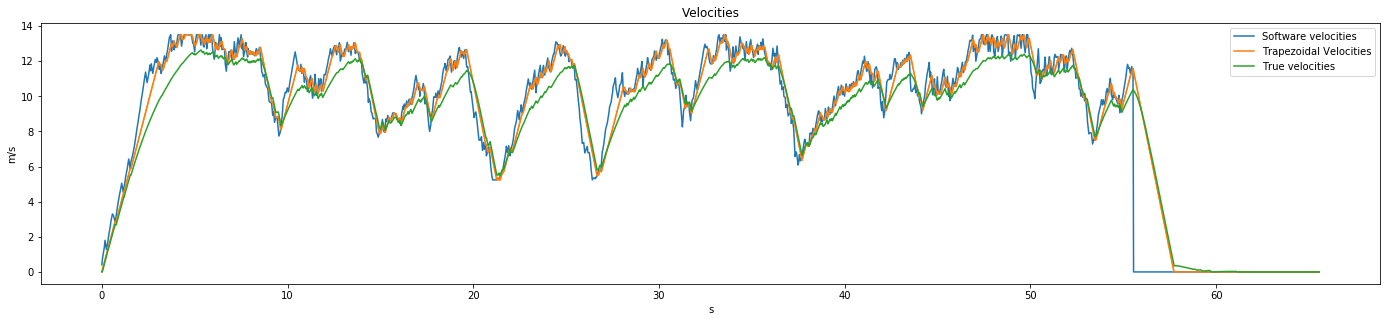

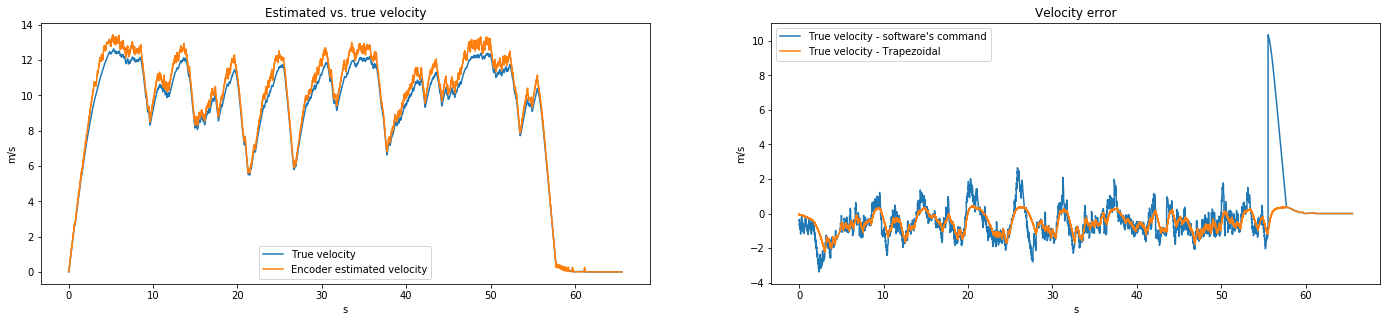

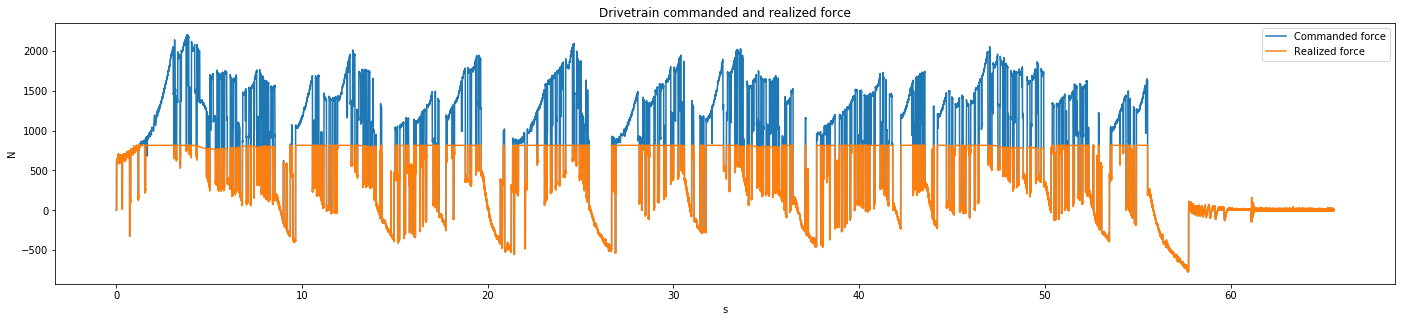

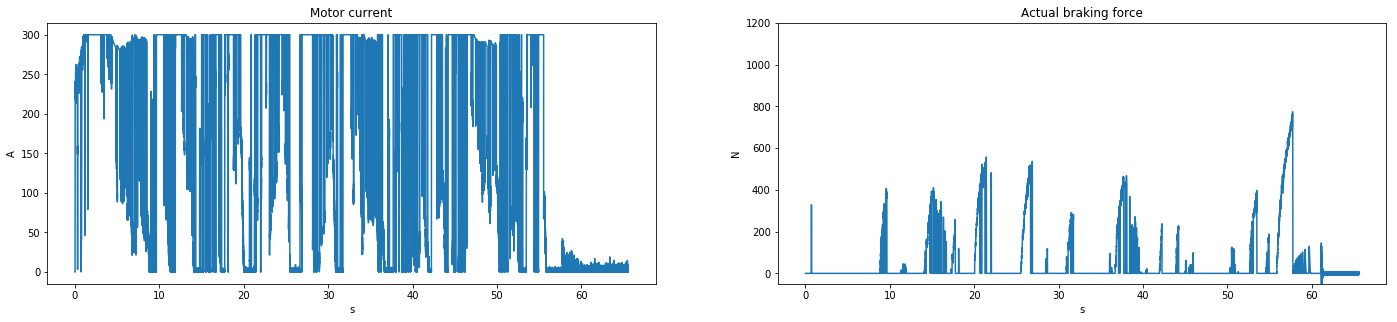

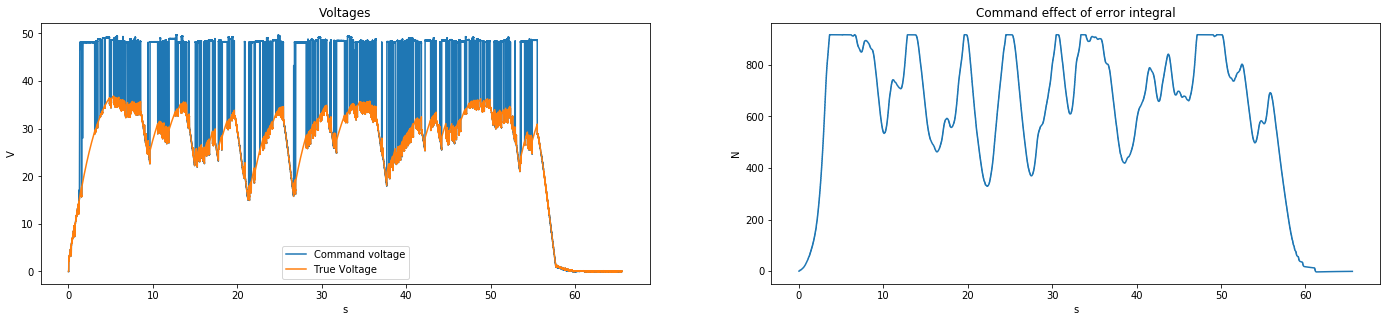

RMS current value: 239.0723769169249
Average brake power dissipation: 329.34220282051933


In [23]:
#Plots!
import matplotlib.pyplot as plt
plot_resolution = 10    #Only plot one of every [this] values to accelerate plotting

times_to_plot = times[::plot_resolution]
true_velocities_to_plot = vel_kart_arr[::plot_resolution]

plt.figure(1, figsize=(24, 4.8))
plt.plot(software_velocity_times_commands[:,0], software_velocity_times_commands[:,1])
plt.plot(times_to_plot, vel_trapezoidal_arr[::plot_resolution])
plt.plot(times_to_plot, true_velocities_to_plot)

plt.title("Velocities")
plt.ylabel("m/s")
plt.xlabel("s")
plt.legend(['Software velocities', 'Trapezoidal Velocities', 'True velocities'])

plt.show()

plt.figure(2, figsize=(24, 4.8))
plt.subplot(1, 2, 1)
plt.plot(times_to_plot, true_velocities_to_plot)
plt.plot(times_to_plot, estimated_vel_arr[::plot_resolution])

plt.title("Estimated vs. true velocity")
plt.legend(['True velocity', "Encoder estimated velocity"])
plt.ylabel("m/s")
plt.xlabel("s")

plt.subplot(1, 2, 2)
plt.plot(times_to_plot, true_velocities_to_plot - software_command_velocities_at_timestep_arr[::plot_resolution])
plt.plot(times_to_plot, true_velocities_to_plot - vel_trapezoidal_arr[::plot_resolution])

plt.title("Velocity error")
plt.legend(["True velocity - software's command", 'True velocity - Trapezoidal'])
plt.ylabel("m/s")
plt.xlabel("s")

plt.show()

plt.figure(3, figsize=(24, 4.8))
plt.plot(times_to_plot, drivetrain_force_cmd_arr[::plot_resolution])
plt.plot(times_to_plot, drivetrain_force_realized_arr[::plot_resolution])

plt.legend(['Commanded force', 'Realized force'])
plt.title("Drivetrain commanded and realized force")
plt.ylabel("N")
plt.xlabel("s")

plt.show()

plt.figure(4, figsize=(24, 4.8))
plt.subplot(1, 2, 1)
plt.plot(times_to_plot, motor_current_arr[::plot_resolution])
plt.title("Motor current")
plt.ylabel("A")
plt.xlabel("s")

plt.subplot(1, 2, 2)
plt.plot(times_to_plot, brake_realized_arr[::plot_resolution])
plt.ylim(-50, 1200)
plt.title("Actual braking force")
plt.ylabel("N")
plt.xlabel("s")
plt.show()


plt.figure(5, figsize=(24, 4.8))
plt.subplot(1, 2, 1)
plt.plot(times_to_plot, voltage_cmd_arr[::plot_resolution])
plt.plot(times_to_plot, voltage_realized_arr[::plot_resolution])

plt.title("Voltages")
plt.ylabel("V")
plt.xlabel("s")
plt.legend(['Command voltage', 'True Voltage'])

plt.subplot(1, 2, 2)
plt.plot(times_to_plot, -k_2f* drive_error_integral_arr[::plot_resolution])

plt.title("Command effect of error integral")
plt.ylabel("N")
plt.xlabel("s")
plt.show()

#Print out some stats
stat_start_time = 10
stat_end_time = 50
off_threshold = 1
stat_start_idx = int(stat_start_time/dt)
stat_end_idx = int(stat_end_time/dt)

rms_current = np.sqrt(np.mean(motor_current_arr[stat_start_idx:stat_end_idx]**2))
avg_brake_power = np.mean(vel_kart_arr[stat_start_idx:stat_end_idx]*brake_realized_arr[stat_start_idx:stat_end_idx])
print("RMS current value:", rms_current)
print("Average brake power dissipation:", avg_brake_power)
